## Importing Libraries

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import ast

import industryMap

## Importing data

In [8]:
# Importing File
user_df = pd.read_csv('../SavedData/Lloyds_users.csv')

# Changing the lists back to normal columns
user_df['user_biz_interaction'] = user_df['user_biz_interaction'].apply(ast.literal_eval)
user_df['user_biz_interaction_frequency'] = user_df['user_biz_interaction_frequency'].apply(ast.literal_eval)
user_df['user_biz_spend'] = user_df['user_biz_spend'].apply(ast.literal_eval)
user_df['user_user_interaction'] = user_df['user_user_interaction'].apply(ast.literal_eval)
user_df['user_user_interaction_frequency'] = user_df['user_user_interaction_frequency'].apply(ast.literal_eval)
user_df['user_user_spend'] = user_df['user_user_spend'].apply(ast.literal_eval)
user_df['user_industry_interaction'] = user_df['user_industry_interaction'].apply(ast.literal_eval)
user_df['user_industry_interaction_frequency'] = user_df['user_industry_interaction_frequency'].apply(ast.literal_eval)
user_df['user_industry_spend'] = user_df['user_industry_spend'].apply(ast.literal_eval)
user_df['user_date_transaction'] = user_df['user_date_transaction'].apply(ast.literal_eval)
user_df['user_date_transaction_freq'] = user_df['user_date_transaction_freq'].apply(ast.literal_eval)

## Get Relative Number of Users

In [10]:
user_num = len(user_df['user_id'])

# If you pick a threshold to high, some industries won't have enough unique users to build the dictionary effectively
# Anywhere above 4% starts to include anyone who has spent at an Accessory store, and in fact runs out of people to include in the list
# This causes the dictionary entries to be of different lengths
user_perc = 20
user_perc_threshold = int(round(user_num * (user_perc / 100), 0))

## Industry Big Spenders

In [27]:
#industry_list = list(set(industryMap.industry_categories.values()))
#industry_list.remove('Accessories')

industry_list = ['Cafes', 'TV/Film', 'Dining']

industry_user_spend = {}

for industry in industry_list:
    
    user_spend_dict = {}
    top_n = user_perc_threshold
    
    for row in range(0, len(user_df)):
        if(industry in user_df['user_industry_interaction'][row]):
            industry_index = user_df['user_industry_interaction'][row].index(industry)
            industry_spend = user_df['user_industry_spend'][row][industry_index]
            
            user_spend_dict[user_df['user_id'][row]] = industry_spend
    
    sorted_user_spend_dict = dict(sorted(user_spend_dict.items(), key=lambda item: item[1], reverse=True)[:top_n])
            
    sorted_user_spend_user_list = list(sorted_user_spend_dict.keys())
    sorted_user_spend_spend_list = list(sorted_user_spend_dict.values())
            
    industry_user_spend[industry + ' users'] = sorted_user_spend_user_list
    industry_user_spend[industry + ' spends'] = sorted_user_spend_spend_list 

## Building Recommendation DataFrame

In [28]:
recommend_user_df = pd.DataFrame(data=industry_user_spend)

## Club Lloyds

In [29]:
# Getting the High Receivers and Creating Dictionary
monthly_received_list_estimate = [x / 12 for x in user_df['received_tx_sum_gbp']]
club_lloyds_ad_dict = dict(zip(user_df['user_id'], monthly_received_list_estimate))
sorted_club_lloyds_ad_dict = dict(sorted(club_lloyds_ad_dict.items(), key=lambda item: item[1], reverse=True)[:top_n])

# Adding this to the dataframe
recommend_user_df['Club Lloyds Target users'] = sorted_club_lloyds_ad_dict.keys()
recommend_user_df['Club Lloyds Target monthly recieves'] = sorted_club_lloyds_ad_dict.values()

## Saving Dataframe to CSV

## Things to Record

In [30]:
# Total Number of People who receive 1800 a month
# Overlapping Bar Chart Showing Spend in Users for the Key Industries

In [31]:
# Total number of people eligible to recieve club lloyds for free
club_lloyds_free = recommend_user_df[recommend_user_df['Club Lloyds Target monthly recieves'] > 1600]
club_lloyds_very_free = recommend_user_df[recommend_user_df['Club Lloyds Target monthly recieves'] > 2000]
print(len(club_lloyds_very_free))
print(str(len(club_lloyds_free) - len(club_lloyds_very_free)))

116
162


In [32]:
# Overlapping Bar Chart Showing Spend in Users for the Key Industries
club_lloyds_deal = recommend_user_df.loc[:, ['Cafes spends', 'TV/Film spends', 'Dining spends']]
club_lloyds_deal = club_lloyds_deal[['Cafes spends', 'TV/Film spends', 'Dining spends']] / 12

tv_cl_list = club_lloyds_deal['TV/Film spends']
dining_cl_list = club_lloyds_deal['Dining spends']
cafes_cl_list = club_lloyds_deal['Cafes spends']

## Graphing the Spending

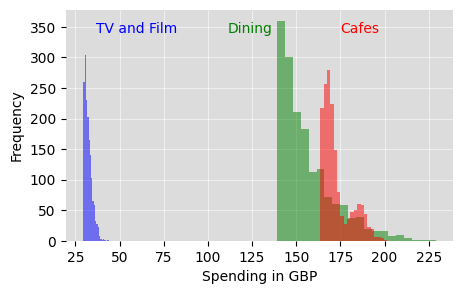

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.gca().set_facecolor('Gainsboro')
plt.grid(True, color='white', linestyle='-', linewidth=0.4, zorder=0)
plt.gca().set_axisbelow(True)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.hist(tv_cl_list, bins=20, alpha=0.5, label='TV and Film Spending', color='blue')
plt.hist(dining_cl_list, bins=20, alpha=0.5, label='Dining Spending', color='green')
plt.hist(cafes_cl_list, bins=20, alpha=0.5, label='Cafes Spending', color='red')

# Calculating the median's of each histogram
median_tv_cl = np.median(tv_cl_list)
median_dining_cl = np.median(dining_cl_list)
median_cafes_cl = np.median(cafes_cl_list)

# Adding labels directly next to the median lines
plt.text(median_tv_cl + 5, plt.ylim()[1]*0.9, 'TV and Film', color='blue')
plt.text(median_dining_cl - 40, plt.ylim()[1]*0.9, 'Dining', color='green')
plt.text(median_cafes_cl + 5, plt.ylim()[1]*0.9, 'Cafes', color='red')

#plt.title('Spending Histogram of Key Industries')
plt.xlabel('Spending in GBP')
plt.ylabel('Frequency')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [50]:
tv_spend_length = len([val for val in tv_cl_list if val > 30])
dining_spend_length = len([val for val in dining_cl_list if val > 100])
cafe_spend_length = len([val for val in cafes_cl_list if val > 170])

print(tv_spend_length)
print(dining_spend_length)
print(cafe_spend_length)

1398
1628
769
